# Segundo trabalho de BDCC
#### João Sá
#### Maio de 2020


## Índice:
- #### [1. Introdução](#intro)
- #### [2. Inspeccionar o dataset](#inspeccionar)
- #### [3. Visualizar o dataset](#visualizar)
    - ##### [3.1. Internamentos](#visualizar-1)
    - ##### [3.2. Items](#visualizar-2)
    - ##### [3.3. Items num internamento](#visualizar-3) 
    - ##### [3.4. Colunas WARNING, ERROR, RESULTSTATUS e CGID](#visualizar-4)
- #### [4. Machine Learning](#ml)
    - ##### [4.1. Preparar vários modelos de regressão](#ml-1)
    - ##### [4.2. Vetorizar e normalizar as features](#ml-2)
    - ##### [4.3. Treinar os modelos](#ml-3)
    - ##### [4.4. Resultados](#ml-4)
- #### [5. Conclusão](#conclusao)


## 1. Introdução <a class="anchor" id="intro"></a>

Este trabalho tem como objetivo processar, visualizar e extrair informação de um dataset de grandes dimensões com dados clínicos.

A realização de qualquer uma destas tarefas está condicionada por um detalhe importante, o tamanho do dataset. No formato csv ocupa cerca de 32.5GB em disco. A solução que surgiu mais imediata para resolver este primeiro problema foi reduzir o tamanho do dataset. A procura por um formato que permitisse comprimir o dataset convergiu em dois formatos: orc e parquet. A escolha recaiu sobre o parquet por já se ter tido experiência no seu uso durante o primeiro trabalho. Este formato faz o armazenamento dos dados por colunas, com dados do mesmo tipo a serem armazenados de forma contígua, permitindo uma compressão muito maior do que aquela que seria possível se os dados estivessem armazenados por linhas. As consultas também se tornam mais rápidas, dado que se torna possível consultar apenas um subconjunto das colunas e não o dataset inteiro. 

Para além disso, o formato parquet também está bem integrado dentro da framework PySpark, que foi usada para a realização das tarefas propostas, por automatizar o processamento dos dados em paralelo. No contexto deste trabalho, o PySpark acabou por se mostrar eficaz, mesmo estando configurado no modo local (sem cluster), numa máquina modesta para a realização deste tipo de tarefas (desktop com um CPU com 4 cores e 8GB de RAM).
A primeira parte do relatório diz respeito à leitura e inspecionamento básico do dataset, a segunda à visualização mais detalhada dos seus conteúdos, e a terceira à criação de modelos de previsão do tempo de internamento de cada paciente.


##### Configurações

In [15]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as F
import time
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import StructType

SEED=123

def debug(starttime, text=""):
    seconds = time.time()-starttime
    print("[ DEBUG %s] took %f seconds (%f minutes)" % (text,seconds,seconds/60 ))
    
spark = SparkSession.builder\
        .master('local[*]')\
        .appName("BDCC")\
        .getOrCreate()  

## 2. Inspeccionar o dataset <a class="anchor" id="inspeccionar"></a>

In [20]:
starttime=time.time()

events_df = spark.read.csv("EVENTS.csv", header=True)
print("#rows: %d  #cols: %d" % (events_df.count(), len(events_df.columns)))

debug(starttime)

#rows: 330712483  #cols: 15

[DEBUG] took 103.583533 seconds (1.726392 minutes)


Mais de 330 milhões de entradas. Vamos guardar o dataset no formato parquet, na esperança de conseguirmos acelerar o seu processamento:

In [19]:
events_df.write.parquet("events.parquet")
events_df = spark.read.parquet("events.parquet")

Com a compressão no formato parquet obteve-se um ficheiro consideravelmente mais pequeno (3.7GB em disco). O dataset tem 15 colunas, vamos ver o que representam:

In [23]:
starttime=time.time()

print(events_df.columns)

debug(starttime)

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'STORETIME', 'CGID', 'VALUE', 'VALUENUM', 'VALUEUOM', 'WARNING', 'ERROR', 'RESULTSTATUS', 'STOPPED']

[DEBUG] took 0.000329 seconds (0.000005 minutes)


Sabemos que o dataset contém informação sobre análises e medições feitas sobre pacientes que deram entrada em unidades de cuidados intensivos. Consultando o portal do MIMIC-III [[1]](https://mimic.physionet.org/mimictables/chartevents/) é possível obter informação mais detalhada sobre o que cada uma destas colunas representa:


- **SUBJECT_ID, HADM_ID e ICUSTAY_ID** - identificadores únicos de pacientes, hospitais e unidades de cuidado intensivo.
- **CHARTTIME** - registo do tempo em que uma observação foi efectuada. **STORETIME** regista o tempo em que a observação foi introduzida manualmente ou validada por um membro do staff clínico. **CGID** é o identificador do prestador de serviço que validou essa medição.
- **VALUE e VALUENUM** - valor da medição efectuada (identificada por ITEMID). Em geral, VALUENUM contém o mesmo valor de VALUE, mas em formato numérico. Caso a informação não seja numérica, VALUENUM fica a null. **VALUEUOM** é a unidade de medida de VALUE.

- **WARNING e ERROR** - identificam se foi retornado um warning sobre o valor e se ocorreu algum erro durante a medição.

- **RESULTSTATUS** e **STOPPED** - RESULTSTATUS identifica o tipo de medição (Manual ou Automatic) e STOPPED identifica se a medição foi, ou não, parada.

Para reduzir um pouco a dimensão do dataset, optou-se por eliminar as seguintes colunas:

- **ROW_ID** - Identifica a entrada na tabela original. Não ajuda a caracterizar nenhum internamento, por isso decidimos eliminá-la.
- **STORETIME** - Já temos o CHARTTIME, que nos diz quando é que as medições foram, de facto, realizadas. Esta informação pareceu-nos não tão relevante, por isso também optámos por deixá-la para trás.



In [491]:
starttime=time.time()

cols = ["ROW_ID","STORETIME"]
events_df = events_df.drop(*cols)

print("Schema após a eliminação das colunas %s:\n" %(cols))
events_df.printSchema()

debug(starttime)

Schema após a eliminação das colunas ['ROW_ID', 'STORETIME']:

root
 |-- SUBJECT_ID: string (nullable = true)
 |-- HADM_ID: string (nullable = true)
 |-- ICUSTAY_ID: string (nullable = true)
 |-- ITEMID: string (nullable = true)
 |-- CHARTTIME: string (nullable = true)
 |-- CGID: string (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: string (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: string (nullable = true)
 |-- ERROR: string (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)


[DEBUG] took 0.012980 seconds (0.000216 minutes)


As colunas foram todas interpretadas como Strings. Vamos fazer cast do tipo das colunas do nosso data frame para ficarem consistentes com o schema original:

In [7]:
starttime=time.time()

events_df = events_df\
            .withColumn("SUBJECT_ID",events_df["SUBJECT_ID"].cast("integer"))\
            .withColumn("HADM_ID",events_df["HADM_ID"].cast("integer"))\
            .withColumn("ICUSTAY_ID",events_df["ICUSTAY_ID"].cast("integer"))\
            .withColumn("ITEMID",events_df["ITEMID"].cast("integer"))\
            .withColumn("CHARTTIME",events_df["CHARTTIME"].cast('timestamp'))\
            .withColumn("CGID",events_df["CGID"].cast('integer'))\
            .withColumn("VALUENUM",events_df["VALUENUM"].cast("integer"))\
            .withColumn("WARNING",events_df["WARNING"].cast("integer"))\
            .withColumn("ERROR",events_df["ERROR"].cast("integer"))

debug(starttime)

[ DEBUG ] took 0.109217 seconds (0.001820 minutes)


Este é o aspecto do data frame após estas transformações:

In [8]:
events_df.printSchema()

root
 |-- ROW_ID: string (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: string (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: integer (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)



Um dos objectivos deste trabalho consiste em criar modelos de machine learning que consigam prever a duração de um internamento (LOS). Esse valor pode pode ser inferido através das datas do primeiro e do último item. Vamos agregar a data mínima e máxima de cada internamento e colocar a diferença numa nova coluna.

In [27]:
starttime=time.time()

events_df = spark.read.parquet("events_pre_processed.parquet")

df = events_df.groupBy(["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])\
                .agg(F.min("CHARTTIME").alias("min_day"), F.max("CHARTTIME").alias("max_day"))

df = df.withColumn(
    'LOS',
    ((F.unix_timestamp('max_day','yyyy-MM-dd hh:mm:ss')) - 
    (F.unix_timestamp('min_day','yyyy-MM-dd hh:mm:ss')))/F.lit(24*60*60)
)

df = df.select(["SUBJECT_ID","HADM_ID","ICUSTAY_ID","LOS"])
df.write.parquet("LOS1.parquet",mode="overwrite")

LOS_df = spark.read.parquet("LOS1.parquet")
events_LOS_df = events_df.join(LOS_df,on=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"], how='inner')

events_LOS_df.write.parquet("events_LOS1.parquet",mode="overwrite")

debug(starttime)


[DEBUG] took 451.288430 seconds (7.521474 minutes)


Após estas transformações, ficámos com um dataset com o seguinte schema:


In [9]:
events_df = spark.read.parquet("events_LOS1.parquet")
events_df.printSchema()

root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: integer (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)
 |-- LOS: double (nullable = true)



Corresponde a uma versão do dataset original sem as colunas ROW_ID e STORETIME mas com uma nova coluna com o LOS de cada paciente. Este dataset está armazenado num ficheiro parquet em disco, a ocupar apenas 1.9GB. Ou seja, conseguiu-se comprimir mais de 18 vezes o tamanho do dataset original.

## 3. Visualizar o dataset <a class="anchor" id="visualizar"></a>

Conhecemos as dimensões e o que cada coluna representa, tudo o resto ainda nos é desconhecido. Nesta parte vamos explorar os conteúdos do dataset.

### 3.1. Internamentos <a class="anchor" id="visualizar-1"></a>

Nesta primeira secção vamos inspeccionar o dataset ao nível dos internamentos: ver a distribuição do número de internamentos, duração média dos internamentos e visualizar a distribuição do número de internamentos por paciente.

##### Número de internamentos e duração média dos internamentos <a class="anchor" id="vis1"></a>

In [10]:
starttime=time.time()

events_LOS_df = spark.read.parquet("events_LOS1.parquet")

events_LOS_df.createOrReplaceTempView("events_sql")
query_df = spark.sql(
    '''
        SELECT SUBJECT_ID, HADM_ID, ICUSTAY_ID, LOS
        FROM events_sql
        GROUP BY SUBJECT_ID, HADM_ID, ICUSTAY_ID, LOS 
    '''
)

query_df.cache()

query_df.groupBy().agg(F.count("SUBJECT_ID").alias("Número de internamentos")).show()
query_df.groupBy().agg(F.avg("LOS").alias("LOS médio")).show()

debug(starttime)

+-----------------------+
|Número de internamentos|
+-----------------------+
|                  60993|
+-----------------------+

+-----------------+
|        LOS médio|
+-----------------+
|4.836640110795959|
+-----------------+

[ DEBUG ] took 38.058567 seconds (0.634309 minutes)


##### Distribuição do número de internamentos por paciente <a class="anchor" id="visualizar"></a>

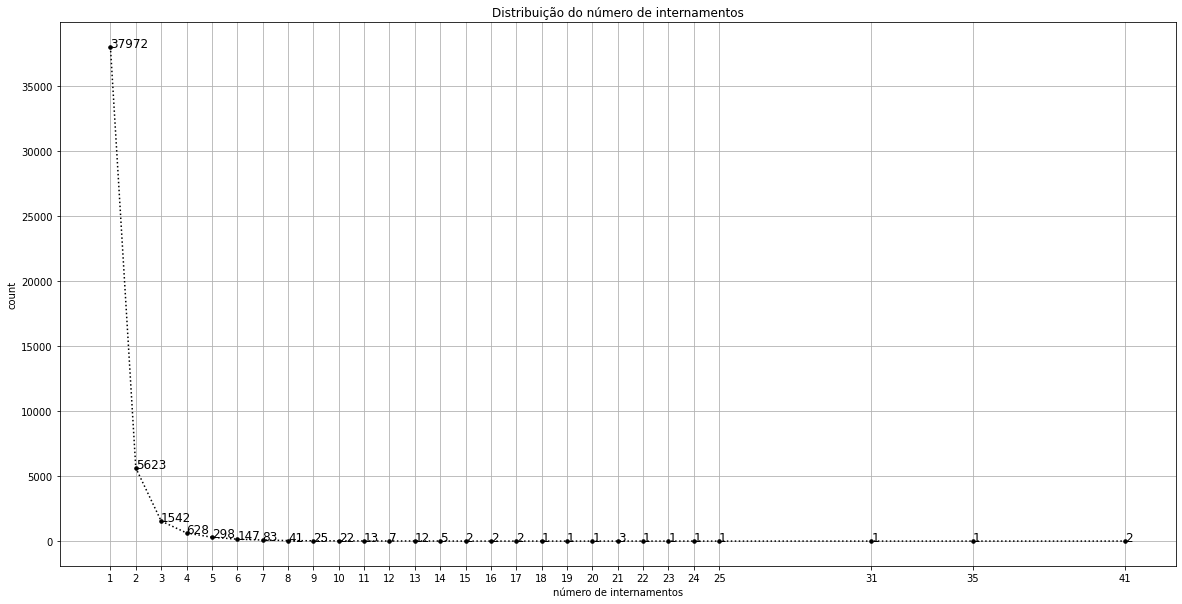


[DEBUG] took 9.342276 seconds (0.155705 minutes)


In [29]:
%matplotlib inline

starttime=time.time()

fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(20, 10))

ax.set_title("Distribuição do número de internamentos")
ax.set_ylabel("count")
ax.set_xlabel("número de internamentos")

df = query_df.groupBy(["SUBJECT_ID"]).count()
df = df.groupBy("count").agg(F.count("count").alias("y")).orderBy("count", ascending=True)

xx = [x[0] for x in df.select("count").collect()]
yy = [y[0] for y in df.select("y").collect()]

ax.plot(xx, yy, "r:.",color="black",markersize=7)

for i, v in enumerate(np.arange(len(xx))):
    ax.text(xx[i], yy[i], yy[i], color='black', size=12)

ax.set_xticks(xx)

plt.grid()
plt.show()
plt.close()

query_df.unpersist()
del df
debug(starttime)

A maioria dos pacientes que foram internados, apenas o foram por uma vez. Muito poucos foram internados múltiplas vezes.

### 3.2. Items  <a class="anchor" id="visualizar-2"></a>

##### Número de items

In [11]:
starttime=time.time()

items_df = events_LOS_df.select("ITEMID")\
            .groupBy("ITEMID").count()\
            .orderBy(["count","ITEMID"],ascending=[False,True])
items_df.cache()

print("Número de itens distintos: %d" % items_df.count())

value = events_LOS_df.filter(events_LOS_df["VALUENUM"].isNotNull()).select("ITEMID").distinct().count()
print("Número de itens distintos com valor numérico associado: %d" % value)

debug(starttime)

Número de itens distintos: 6457
Número de itens distintos com valor numérico associado: 2882
[ DEBUG ] took 41.687488 seconds (0.694791 minutes)


A maior parte dos itens não tem nunca um valor numérico associado. Isto significa que se usarmos exclusivamente o valor dos itens como features para os modelos de aprendizagem, vamos estar a desperdiçar a maior parte dos itens.

##### Items mais frequentes 

In [32]:
starttime=time.time()

items_df.show(5)

debug(starttime)

+------+-------+
|ITEMID|  count|
+------+-------+
|   211|5174633|
|   742|3461124|
|   646|3415655|
|   618|3383891|
|   212|3300119|
+------+-------+
only showing top 5 rows


[DEBUG] took 0.117963 seconds (0.001966 minutes)


O item 211 é o mais frequente. Neste momento ainda não temos nenhum tipo de informação sobre o que é que os itens representam.

A tabela D_ITEMS possui informação sobre os itens, incluindo uma coluna label com uma descrição sobre cada um deles. Para satisfazer a nossa curiosidade, vamos carregá-la e ver o que é que os itens mais frequentes representam:


In [33]:
starttime=time.time()

items_table = spark.read.csv("D_ITEMS.csv",header=True)
items_table.filter((items_table["ITEMID"]==211) \
                   | (items_table["ITEMID"]==742)\
                   | (items_table["ITEMID"]==646)\
                   | (items_table["ITEMID"]==618)\
                   | (items_table["ITEMID"]==212)               
                  ).select(["ITEMID","LABEL"]).show()
debug(starttime)

+------+----------------+
|ITEMID|           LABEL|
+------+----------------+
|   618|Respiratory Rate|
|   211|      Heart Rate|
|   212|    Heart Rhythm|
|   646|            SpO2|
|   742|      calprevflg|
+------+----------------+


[DEBUG] took 0.694438 seconds (0.011574 minutes)


A medição da frequência cardíaca é o evento mais comum.

Embora já soubéssemos que os itens representavam observações ou medições efectuadas sobre os pacientes, ainda nos pareciam coisas um pouco abstractas, dado que apenas víamos os IDs e nunca o seu significado concreto. Agora já temos uma ideia mais clara sobre o que representam. 

Vamos ver qual o aspecto da distribuição dos itens:


##### Distribuição dos items 

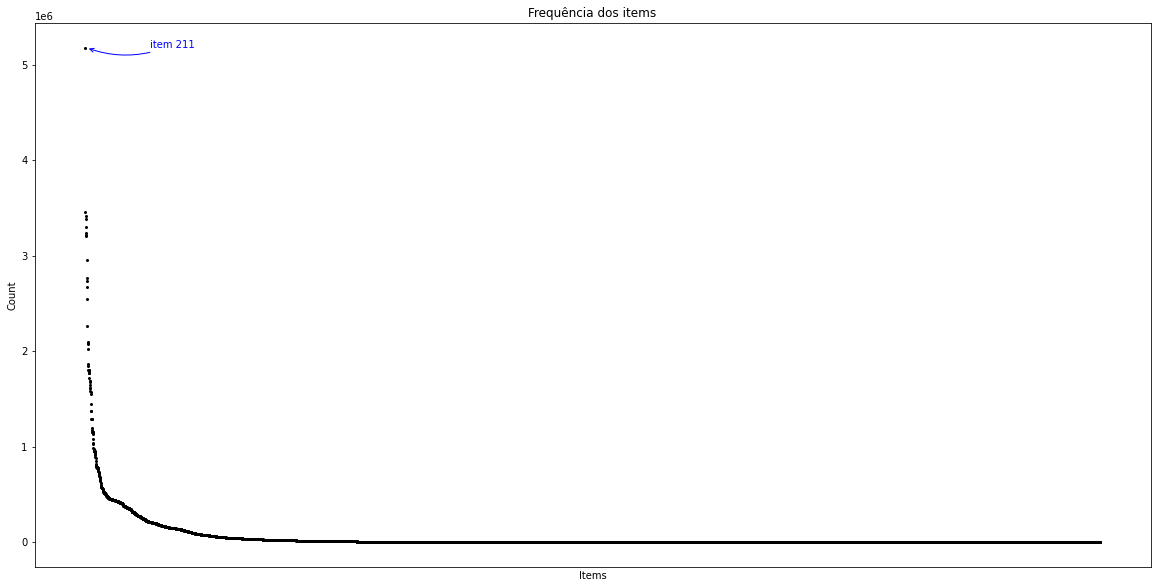

[ DEBUG ] took 1.193473 seconds (0.019891 minutes)


In [8]:
%matplotlib inline

starttime=time.time()

fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(20, 10))

yy = [y[1] for y in items_df.collect()]
xx = [x[0] for x in items_df.collect()]
xx_= list(range(len(xx)))
ax.plot(xx_, yy, 'o', color='black',markersize=2)
plt.xlabel("Items")
plt.ylabel("Count")
plt.title("Frequência dos items")
plt.yscale('linear')
plt.xscale('linear')

ax.annotate("item %d" % xx[0], xy=(xx_[0]+10, yy[0]), xytext=((xx[0]+200), yy[0]),
            arrowprops=dict(arrowstyle="->",
            connectionstyle="arc3,rad=-0.2",color='blue'),color='blue')
plt.xticks([])
plt.show()
plt.close()

del yy,xx,xx_
items_df.unpersist()
debug(starttime)

Mais uma vez estamos perante uma power law. Poucos itens ocorrem muito frequentemente enquanto a maioria ocorre muito pouca frequência.


##### Distribuição dos valores para o item mais frequente

Já vimos que alguns itens têm uma medição ou observação associada, indicada em VALUE ou VALUENUM. Vamos agora ver qual a distribuição desses valores para o item mais frequente (medição da frequência cardíaca).

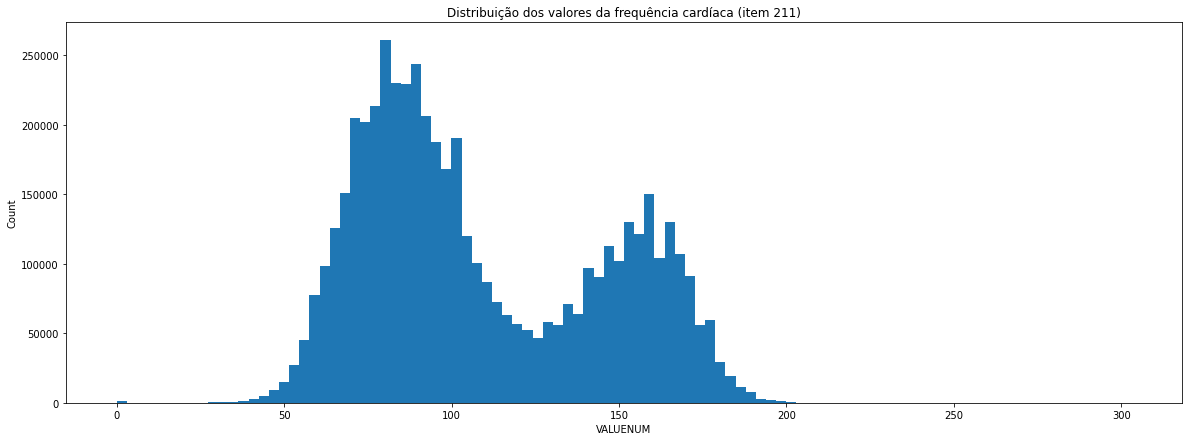


[DEBUG] took 29.670448 seconds (0.494507 minutes)


In [40]:
starttime=time.time()

item_211 = events_LOS_df\
            .filter(events_LOS_df["ITEMID"]==211)\
            .filter(events_LOS_df["VALUENUM"].isNotNull())\
            .select("VALUENUM")

values = item_211.collect()
values = [x[0] for x in values]

fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(20, 7))

plt.hist(values,bins=100)
plt.xlabel("VALUENUM")
plt.ylabel("Count")
plt.title("Distribuição dos valores da frequência cardíaca (item 211)")
plt.show()
plt.close()

del item_211, values

debug(starttime)

A distribuição é interessante, tem dois máximos locais. O primeiro pico parece representar os valores normais da frequência cardíaca que, em repouso, oscila entre os 60 e os 100 batimentos por minuto [[2](https://medlineplus.gov/ency/article/003399.htm)].

### 3.3. Items num internamento <a class="anchor" id="visualizar-3"></a>

Nesta parte vamos criar gráficos para a visualização dos itens de um paciente ao longo do tempo. Para efeitos demonstrativos, optou-se por seleccionar o primeiro internamento que nos surge no data frame:

In [10]:
starttime=time.time()

row = events_LOS_df.rdd.take(1)[0]
data = dict(zip(row.__fields__, [row[field] for field in row.__fields__]))

for k in data:
    print ("%s: %s"%(k,data[k]))

del row
debug(starttime)

SUBJECT_ID: 11464
HADM_ID: 171574
ICUSTAY_ID: 295297
ITEMID: 161
CHARTTIME: 2132-10-31 15:05:00
CGID: 17590
VALUE: PVC's
VALUENUM: None
VALUEUOM: None
ERROR: None
RESULTSTATUS: None
STOPPED: NotStopd
LOS: 2.359722222222222
[ DEBUG ] took 0.990424 seconds (0.016507 minutes)


Agora, vamos obter os itens associados a este internamento, e visualizar a ocorrência de cada um deles durante o período total de internamento.

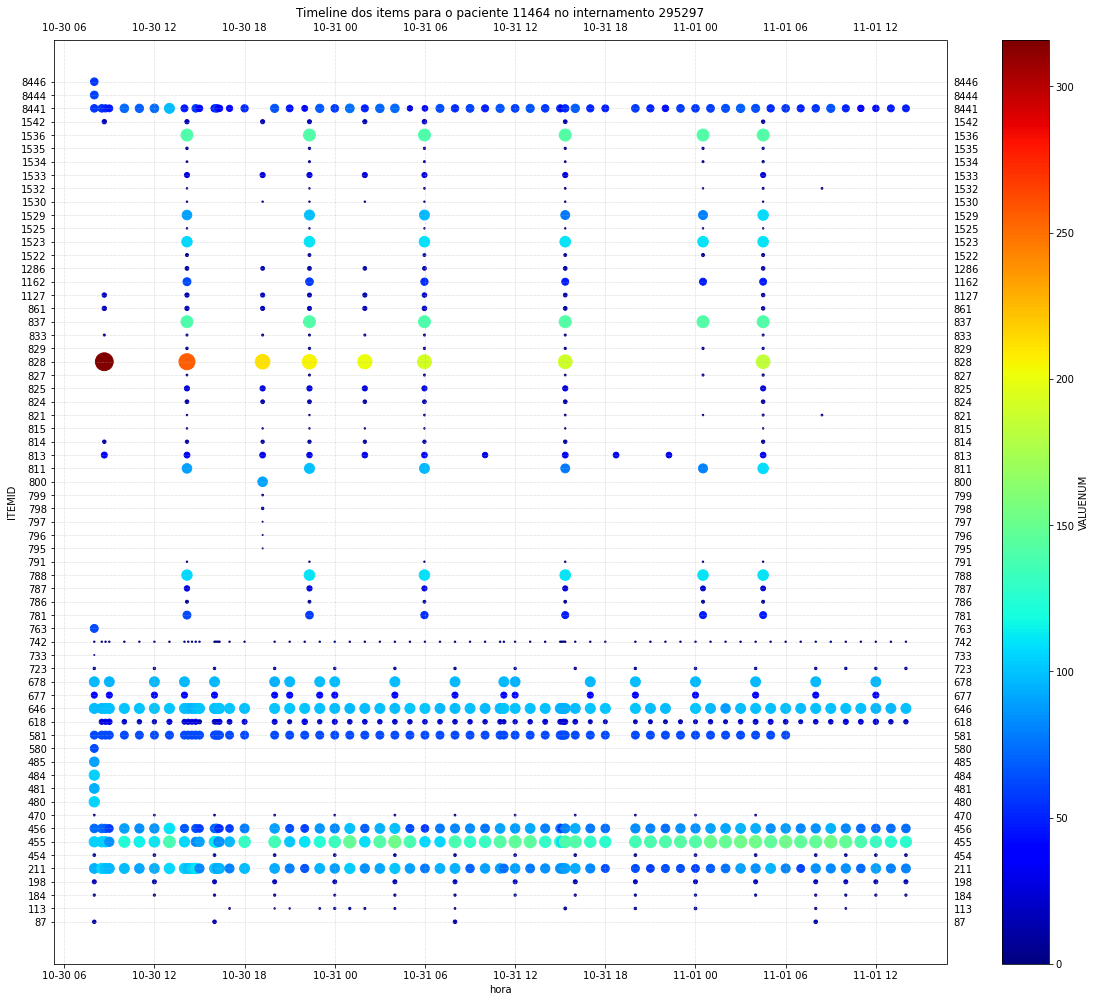

[ DEBUG ] took 24.550489 seconds (0.409175 minutes)


In [17]:
from matplotlib import cm
%matplotlib inline

starttime=time.time()

def plot_items(xx,yy,zz,title=""):
    sizes = [x+1 for x in zz]

    fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(20, 17))

    plt.title(title)
    plt.ylabel("ITEMID")
    plt.xlabel("hora")

    p = ax.scatter(xx,yy,c=zz,s=sizes,cmap=plt.cm.jet)
    plt.grid(linestyle=':', linewidth=.5)

    plt.tick_params(axis='y', which='both', labelright=True)
    plt.tick_params(axis='x', which='both', labeltop=True)
    plt.colorbar(p, label='VALUENUM')  

    plt.show()
    plt.close()
    df_items_full.unpersist()


df_full_timeline = events_LOS_df\
            .filter(events_LOS_df["ICUSTAY_ID"]==data["ICUSTAY_ID"])\
            .select(["ICUSTAY_ID","ITEMID","CHARTTIME","VALUE","VALUENUM","VALUEUOM","LOS"])\
            .orderBy(["CHARTTIME","ITEMID"])
df_full_timeline.cache()

df_items_full = df_full_timeline\
            .select(["CHARTTIME","ITEMID","VALUENUM"])\
            .orderBy(["ITEMID","CHARTTIME","VALUE"], ascending=[True,True,True])
df_items_full = df_items_full.dropna()
df_items_full.cache()

xx = [x["CHARTTIME"] for x in df_items_full.select("CHARTTIME").collect()]
yy = [str(x["ITEMID"]) for x in df_items_full.select("ITEMID").collect()]
zz = [x["VALUENUM"] for x in df_items_full.select("VALUENUM").collect()]
title = "Timeline dos items para o paciente %s no internamento %s" % (data["SUBJECT_ID"],data["ICUSTAY_ID"])

plot_items(xx, yy, zz, title)
    
del xx, yy, zz
debug(starttime)

Os intervalos entre as linhas de referência verticais representam intervalos de tempo de 6 horas. É possível ver que, em geral, as medições/observações a que os itens correspondem foram feitas em conjunto, separados por intervalos de tempo mais ou menos regulares. Os valores, representados pela cor/tamanho, também não diferem muito para os mesmos itens. 

Este gráfico abrange o tempo total de internamento deste paciente. Engloba muitos itens e alguns acabam por ficar sobrepostos. Se traçarmos o mesmo gráfico mas apenas para um dia, conseguimos ter uma visão um pouco mais nítida, com menos sobreposições:

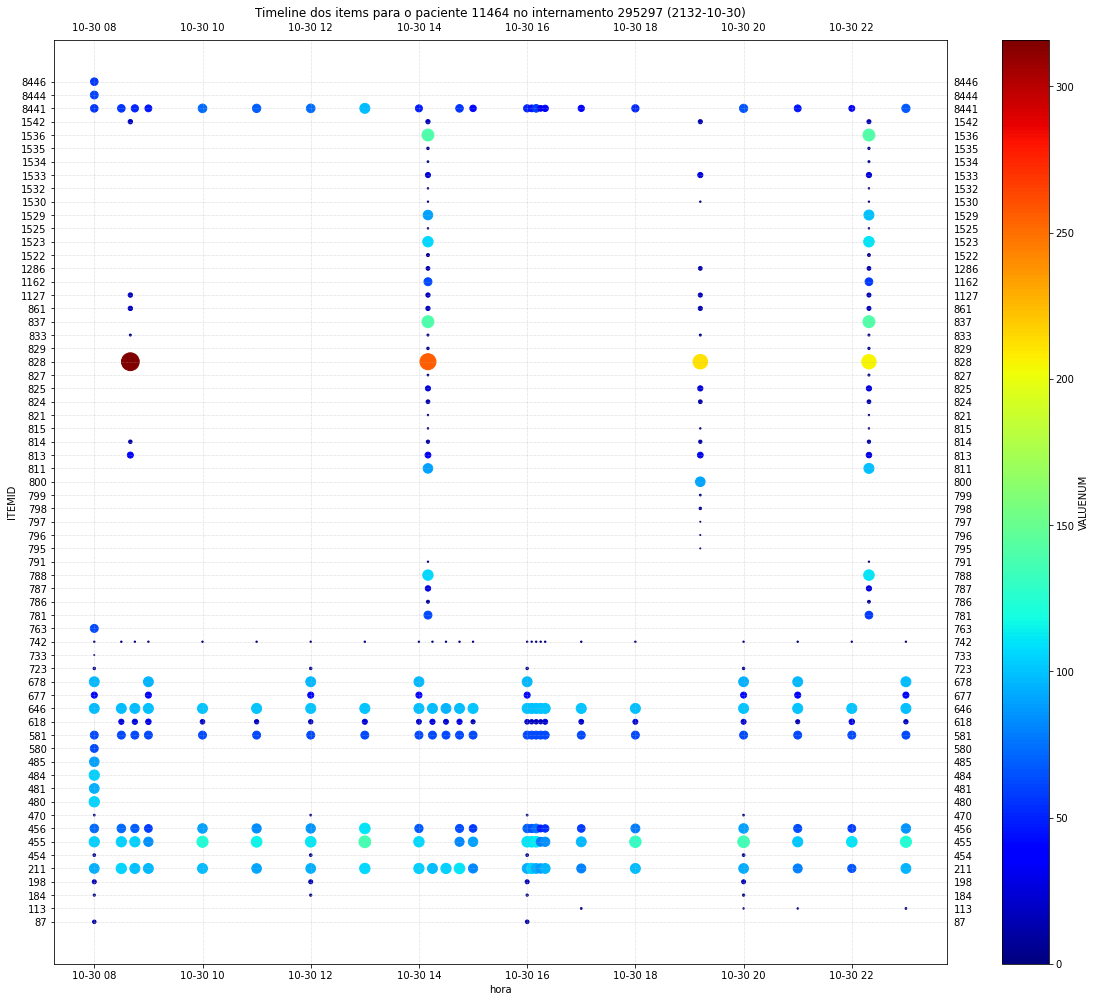

[ DEBUG ] took 12.886350 seconds (0.214772 minutes)


In [23]:
from matplotlib import cm
import datetime

%matplotlib inline

starttime=time.time()

first_day = df_full_timeline.take(1)[0].CHARTTIME
first_day = datetime.date(first_day.year,first_day.month,first_day.day)

df_items = df_full_timeline.filter(df_full_timeline["CHARTTIME"].contains(first_day))

df_items = df_items.select(["CHARTTIME","ITEMID","VALUENUM"]).orderBy(["ITEMID","CHARTTIME","VALUE"]).dropna()
df_items.cache()

xx = [x["CHARTTIME"] for x in df_items.select("CHARTTIME").collect()]
yy = [str(x["ITEMID"]) for x in df_items.select("ITEMID").collect()]
zz = [x["VALUENUM"] for x in df_items.select("VALUENUM").collect()]
title = "Timeline dos items para o paciente %s no internamento %s (%s)" % \
                        (data["SUBJECT_ID"],data["ICUSTAY_ID"], first_day)

plot_items(xx,yy,zz, title)

df_full_timeline.unpersist()
del xx, yy, zz

debug(starttime)

Também podemos obter uma representação das frequências dos itens deste internamento. Vamos representá-las através de dois gráficos de barras. Um para o tempo total do internamento e outro para o primeiro dia:

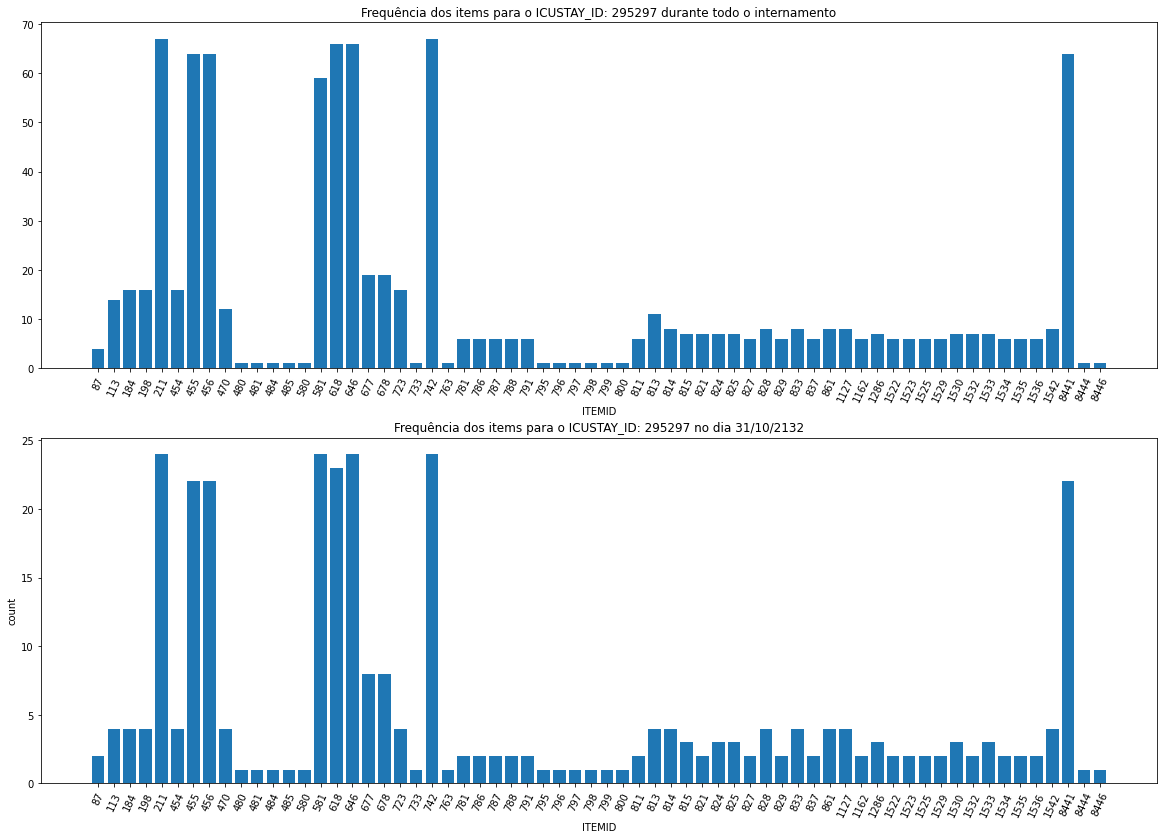

[ DEBUG ] took 19.486405 seconds (0.324773 minutes)


In [24]:
starttime=time.time()

items_full = [item[0] for item in df_items_full.select("ITEMID").collect()]
items_day  = [item[0] for item in df_items.select("ITEMID").collect()]

count_full, count_day = {}, {}
for i in items_full:
    count_full[i] = count_full.get(i, 0) + 1
for i in items_day:
    count_day[i] = count_day.get(i, 0) + 1

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 14))

ax[0].set_title("Frequência dos items para o ICUSTAY_ID: %d durante todo o internamento" % 
                (data["ICUSTAY_ID"]))
ax[0].set_xlabel("ITEMID"), ax[1].set_ylabel("count")
ax[0].bar(np.arange(len(count_full.keys())) ,list(count_full.values()))
ax[0].set_xticklabels(list(count_full.keys()), rotation=65)
ax[0].set_xticks(np.arange(len(count_full.keys())))

ax[1].set_title("Frequência dos items para o ICUSTAY_ID: %d no dia %d/%d/%d" % 
                (data["ICUSTAY_ID"], data["CHARTTIME"].day, data["CHARTTIME"].month, data["CHARTTIME"].year))
ax[1].bar(np.arange(len(count_day.keys())) ,list(count_day.values()))
ax[1].set_xlabel("ITEMID"), ax[1].set_ylabel("count")
ax[1].set_xticklabels(list(count_day.keys()), rotation=65)
ax[1].set_xticks(np.arange(len(count_day.keys())))

plt.show()

plt.close()
df_items_full.unpersist()
df_items.unpersist()

debug(starttime)

### 3.4. Colunas WARNING, ERROR, RESULTSTATUS e CGID <a class="anchor" id="visualizar-4"></a>

O dataset tem também informação sobre o CGID que fez a medição, se a medição soltou um aviso (WARNING), e o status da medição (automática ou manual). Vamos contrastar estes valores com o LOS médio:

In [27]:
starttime=time.time()

events_LOS_df.groupBy("WARNING").agg(F.count("WARNING"),F.avg("LOS")).dropna().show()

events_LOS_df.groupBy("ERROR").agg(F.count("ERROR"),F.avg("LOS")).dropna().show()

events_LOS_df.groupBy("RESULTSTATUS").agg(F.count("RESULTSTATUS"),F.avg("LOS")).dropna().show()

debug(starttime)

+-------+--------------+------------------+
|WARNING|count(WARNING)|          avg(LOS)|
+-------+--------------+------------------+
|      1|       2234211|11.808052905601924|
|      0|     107126535|12.045201317870399|
+-------+--------------+------------------+

+-----+------------+------------------+
|ERROR|count(ERROR)|          avg(LOS)|
+-----+------------+------------------+
|    1|      132496|13.861724216621916|
|    0|   109228250|12.038147084103588|
+-----+------------+------------------+

+------------+-------------------+------------------+
|RESULTSTATUS|count(RESULTSTATUS)|          avg(LOS)|
+------------+-------------------+------------------+
|       Final|            8801556|16.254940506791808|
|      Manual|             701918|18.038214091998928|
+------------+-------------------+------------------+

[ DEBUG ] took 83.976559 seconds (1.399609 minutes)


A maior parte das medições não soltaram nem um warning nem ou um erro. Em MIMIC-III [[1]](https://mimic.physionet.org/mimictables/chartevents/) é-nos dito que RESULTSTATUS indica se uma medição foi automática ou manual, por isso deduzimos que "Final" represente as medições automáticas, e que estas são as mais frequentes. De qualquer das formas, parece-nos não haver grande causalidade entre a diferença destes valores e o respectivo LOS médio.

CGID identifica o membro do staff clínico que realizou ou validou a medição. Vamos visualizar a relação entre os diferentes CGIDs e o LOS médio:


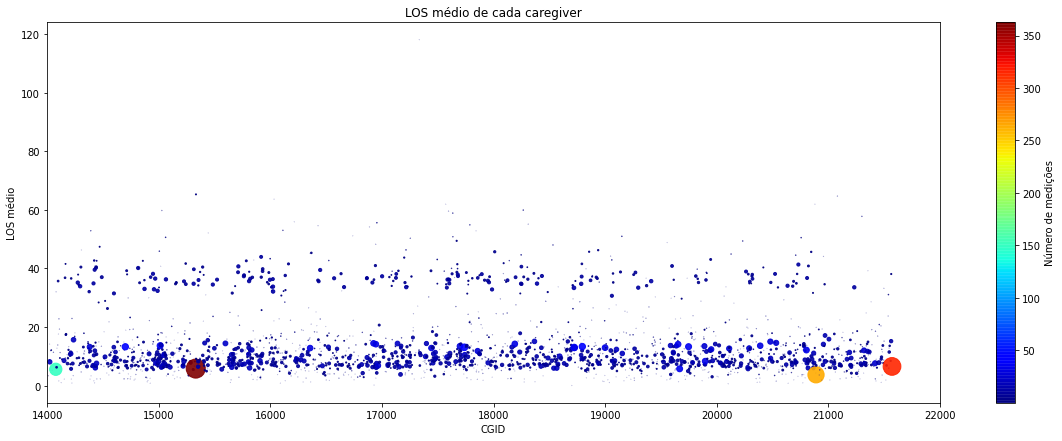

[ DEBUG ] took 32.804667 seconds (0.546744 minutes)


In [28]:
%matplotlib inline

starttime=time.time()

df_CGID = events_LOS_df.select("SUBJECT_ID","ICUSTAY_ID","CGID","LOS").distinct()
df_CGID = df_CGID.groupBy("CGID").agg(F.count('LOS'), F.mean('LOS'))\
            .orderBy("CGID", ascending=True)

df_CGID.cache()

xx = [x["CGID"] for x in df_CGID.select("CGID").collect()]
yy = [x["avg(LOS)"] for x in df_CGID.select("avg(LOS)").collect()]
zz = np.array([x["count(LOS)"] for x in df_CGID.select("count(LOS)").collect()])

xx_,yy_,zz_=[],[],[]
for i in range(0,len(xx)):
    if(xx[i]!=None):
        xx_.append(xx[i])
        yy_.append(yy[i])
        zz_.append(zz[i])
xx_,yy_,zz_=np.array(xx_),np.array(yy_),np.array(zz_)

fig, ax = plt.subplots(nrows=1, ncols=1,  figsize=(20, 7))

plt.title("LOS médio de cada caregiver")
plt.ylabel("LOS médio")
plt.xlabel("CGID")

p = ax.scatter(xx_,yy_,s=zz_/100,c=zz_/100,cmap=plt.cm.jet,alpha=.9)

plt.xlim([14000, 22000]) 
plt.colorbar(p, label='Número de medições')  

plt.show()
plt.close()

df_CGID.unpersist()
debug(starttime)

A média do LOS dos pacientes com que cada caregiver esteve em contacto não parece variar muito. Há quatro caregivers que estiveram envolvidos num grande número de internamentos, e o LOS médio desses internamentos não varia muito entre eles. Alguns caregivers têm LOS médios mais elevados, mas estiveram envolvidos em poucos internamentos. A ideia aqui era tentar ver se havia um conjunto de caregivers que estivesse dedicado ao tratamento de pacientes em internamentos mais prolongados, o que parece não ser o caso.

## 4. Machine Learning <a class="anchor" id="ml"></a>

Esta parte tem como objectivo a criação de modelos de machine learning que consigam prever o valor do LOS. Optou-se por criar três conjuntos de modelos, o primeiro usando como features a média dos valores das observações (VALUENUM) durante o internamento completo, o segundo usando a frequência média das observações diárias de cada item (ITEMIDs) em relação ao internamento completo, e um terceiro usando as features dos dois conjuntos anteriores. Cada conjunto é composto por quatro modelos utilizando algoritmos de aprendizagem diferentes: regressão linear, árvores de decisão, random forest e gradient-boosting trees. Os 12 modelos foram treinados usando o mesmo conjunto de treinos, com 75% dos internamentos. Os 25% restantes foram usados para avaliar a performance dos modelos através das métricas RMSE, MAE, SME e R2.

### 4.1. Preparação dos dados para os vários modelos de regressão <a class="anchor" id="ml-1"></a>

#### Conjunto de modelos 1 - Média dos valores dos items de cada internamento (VALUENUM) como features

In [4]:
starttime=time.time()

events_LOS_df = spark.read.parquet("events_LOS1.parquet")

""" Agregar a média dos valores dos ITEMID para cada internamento """
events_LOS_agg_df = events_LOS_df\
                    .groupBy(["SUBJECT_ID","ICUSTAY_ID","ITEMID","LOS"])\
                    .agg(F.avg("VALUENUM").alias("avg"))

events_LOS_agg_df.write.parquet("events_valuenum_avg1.parquet", mode="overwrite")

""" Eliminar NAs e transpôr os items para colunas """
events_valuenum_avg = spark.read.parquet("events_valuenum_avg1.parquet")

items = list(dict.fromkeys([x[0] for x in events_valuenum_avg.select("ITEMID").collect()]))

events_LOS_agg_items_df = events_valuenum_avg.groupBy(["SUBJECT_ID","ICUSTAY_ID","LOS"])\
                    .pivot("ITEMID", items)\
                    .agg(F.first("avg"))

""" Preencher nulls com zero """
events_LOS_agg_items_df = events_LOS_agg_items_df.na.fill(0)
events_LOS_agg_items_df.write.parquet("events_valuenum_avg_cols1.parquet", mode="overwrite")
events_valuenum_avg_cols = spark.read.parquet("events_valuenum_avg_cols1.parquet")

print("#rows: %d  #cols: %d" % (events_valuenum_avg_cols.count(), len(events_valuenum_avg_cols.columns)))

debug(starttime)

#rows: 60993  #cols: 6460

[DEBUG] took 1695.598353 seconds (28.259973 minutes)


#### Conjunto de modelos 2 - Média do número de cada item para cada internamento como features

In [319]:
starttime=time.time()

events_LOS_df = spark.read.parquet("events_LOS1.parquet")

#Agregar a média das frequências dos ITEMID para cada internamento 
events_LOS_agg_df = events_LOS_df\
                .groupBy(["SUBJECT_ID","ICUSTAY_ID","ITEMID","LOS", 
                          F.date_format('CHARTTIME','yyyy-MM-dd').alias("day")])\
                .agg(F.count("ITEMID").alias("count"))

events_LOS_agg_df.write.parquet("temp.parquet", mode="overwrite")
df = spark.read.parquet("temp.parquet")

df = df.groupBy(["SUBJECT_ID","ICUSTAY_ID","ITEMID","LOS"]).agg(F.sum("count").alias("sum"))
df.printSchema()
df = df.withColumn('avg_count', df["sum"] /df["LOS"])\
        .select(["SUBJECT_ID","ICUSTAY_ID","ITEMID","avg_count","LOS"])
df.printSchema()

df.write.parquet("temp2.parquet", mode="overwrite")
df = spark.read.parquet("temp2.parquet")

items = list(dict.fromkeys([x[0] for x in df.select("ITEMID").collect()]))

df = df.groupBy(["SUBJECT_ID","ICUSTAY_ID","LOS"])\
                    .pivot("ITEMID", items)\
                    .agg(F.first("avg_count"))

df = df.na.fill(0)
df.write.parquet("events_count_avg_cols.parquet", mode="overwrite")

df = spark.read.parquet("events_count_avg_cols.parquet")

print("#rows: %d  #cols: %d" % (df.count(), len(df.columns)))

debug(starttime)

#rows: 60993  #cols: 6460
[ DEBUG ] took 5.483891 seconds (0.091398 minutes)


#### Conjunto de modelos 3 - Média dos valores e do número de items como features

In [124]:
starttime=time.time()

df_avg_value = spark.read.parquet("events_valuenum_avg_cols1.parquet")
df_avg_count = spark.read.parquet("events_count_avg_cols.parquet")

df_avg_count = df_avg_count.select(
    [F.col(c).alias("_"+c) if c not in ["SUBJECT_ID","ICUSTAY_ID","LOS"] else F.col(c) 
    for c in df_avg_count.columns]
)

df_full = df_avg_value.join(df_avg_count, on=["SUBJECT_ID","ICUSTAY_ID","LOS"],how="inner")

df_full = df_full.na.fill(0)
df_full.write.parquet("counts_and_values.parquet", mode="overwrite")

debug(starttime)


[DEBUG] took 3460.516064 seconds (57.675268 minutes)

[DEBUG] took 3460.541593 seconds (57.675693 minutes)


Temos como objectivo criar três conjuntos de modelos usando features diferentes.
Para o conjunto de modelos 1, criou-se um data frame agregando a média dos valores dos diferentes itens para cada internamento. Para o segundo conjunto, agregou-se a frequência média dos itens para cada internamento (número de vezes que um item ocorreu sobre o LOS do internamento). 
Feita a agregação, transpôs-se os itens para colunas. Obteve-se dois datasets com muitas colunas, tantas quanto o número de itens, que são as nossas features, mais a coluna com o LOS, que é a variável target, e as colunas SUBJECT_ID e ICUSTAY_ID que identificam o internamento. 
O terceiro conjunto de modelos usa como features a combinação das features dos dois modelos anteriores, e foi obtido fazendo join dos dois datasets.
Estas são as dimensões dos três conjuntos de features:


In [318]:
starttime=time.time()

df = spark.read.parquet("events_count_avg_cols.parquet")
print("Conjunto de modelos 1:  #rows: %d  #cols: %d" % (df.count(), len(df.columns)))

df = spark.read.parquet("events_valuenum_avg_cols1.parquet")
print("Conjunto de modelos 2:  #rows: %d  #cols: %d" % (df.count(), len(df.columns)))

df = spark.read.parquet("counts_and_values.parquet")
print("Conjunto de modelos 3:  #rows: %d  #cols: %d" % (df.count(), len(df.columns)))

del df
debug(starttime)

Conjunto de modelos 1:  #rows: 60993  #cols: 6460
Conjunto de modelos 2:  #rows: 60993  #cols: 6460
Conjunto de modelos 3:  #rows: 60993  #cols: 12917
[ DEBUG ] took 21.178452 seconds (0.352974 minutes)


### 4.2. Vetorizar e normalizar as features para os três conjuntos de modelos <a class="anchor" id="ml-2"></a>

In [129]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler

starttime=time.time()

def vectorize(model_set, df, outputCol):
    starttime1=time.time()

    """ Agrupar as features num vetor """
    features =  [x for x in df.columns if x not in ['SUBJECT_ID','ICUSTAY_ID','LOS']]
    assembler = VectorAssembler(
        inputCols=features,
        outputCol='features')

    df =assembler.transform(df) 
    df=df.select(['SUBJECT_ID','ICUSTAY_ID','features','LOS'])

    """ Normalizar as features """
    maxAbsScaler = MaxAbsScaler(inputCol="features", outputCol=outputCol)
    scaler = maxAbsScaler.fit(df)
    df = scaler.transform(df).select(['SUBJECT_ID','ICUSTAY_ID',outputCol,'LOS'])
    return df

model_set="avg_value"
file_name="scaled_%s_df.parquet" % (model_set)
df1 = spark.read.parquet("events_valuenum_avg_cols1.parquet")
df1 = vectorize(model_set, df1, "features_avg_valuenum")
df1.write.parquet(file_name, mode="overwrite")

model_set="avg_count"
file_name="scaled_%s_df.parquet" % (model_set)
df2 = spark.read.parquet("events_count_avg_cols.parquet")
df2 = vectorize(model_set, df2, "features_avg_count")
df2.write.parquet(file_name, mode="overwrite")

model_set="full"
file_name="scaled_%s_df.parquet" % (model_set)
df3 = spark.read.parquet("counts_and_values.parquet")
df3 = vectorize(model_set, df3, "features_full")
df3.write.parquet(file_name, mode="overwrite")


""" join scale_avg_value com scale_avg_count """
df1 = spark.read.parquet("scaled_avg_value_df.parquet")
df2 = spark.read.parquet("scaled_avg_count_df.parquet")
df3 = spark.read.parquet("scaled_full_df.parquet")

df = df1.join(df2, ["SUBJECT_ID","ICUSTAY_ID","LOS"], "inner")\
        .join(df3,["SUBJECT_ID","ICUSTAY_ID","LOS"], "inner")

df.write.parquet("all_features.parquet")

del df, df1, df2, df3, model_set
debug(starttime)

root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- LOS: double (nullable = true)

took 153 seconds
root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- LOS: double (nullable = true)

took 124 seconds
root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- LOS: double (nullable = true)

took 366 seconds
took 1196 seconds


Vetorizaram-se e normalizaram-se as features dos três conjuntos de modelos. Ou seja, passou-se a ter uma única coluna com os valores das features normalizados e contidos num vector. Optou-se por juntar os três vetores de features (dos três conjuntos de modelos) no mesmo data frame para facilitar a divisão nos casos de treino e nos casos de teste, por forma a poder-se treinar e avaliar todos os modelos usando os mesmos casos de treino e de teste.

### 4.3. Treinar os modelos <a class="anchor" id="ml-3"></a>

##### Divisão dos internamentos em casos de treino e de teste

In [115]:
starttime=time.time()

model_sets__features = {
    "avg_value": "features_avg_valuenum",
    "avg_count": "features_avg_count", 
    "full": "features_full"
}

models = {}

df = spark.read.parquet("all_features.parquet")

train, test = df.randomSplit([.75,.25], seed=SEED)
print("#Internamentos para treino: %d" % (train.count()))
print("#Internamentos para teste:  %d" % (test.count()))

debug(starttime)

#Internamentos para treino: 45783
#Internamentos para teste:  15210
[ DEBUG ] took 7.789834 seconds (0.129831 minutes)


##### Treinar vários modelos de regressão

In [109]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressionModel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

starttime=time.time()

def training(train_set, test_set, model_set, features, target="LOS"):   
    
    global models
    models[model_set]= {}
    
    def regressionModel(regressor, train_data, test_data, target):
        model = regressor.fit(train_data)
        predictions = model.transform(test_data)
        return model, predictions

    regressors = [
        ("linear regression",LinearRegression(featuresCol=features,labelCol=target, maxIter=50,regParam=0.3, elasticNetParam=0.8)),
        ("decision trees",   DecisionTreeRegressor(featuresCol=features, labelCol=target)),
        ("random forest",    RandomForestRegressor(featuresCol=features, labelCol=target)),
        ("gradient boosted", GBTRegressor(featuresCol =features,labelCol=target, maxIter=50))
    ]
    
    for name, regressor in regressors:
        starttime1=time.time()
        model, predictions = regressionModel(regressor, train, test,target="LOS")
        models[model_set][name]={}
        models[model_set][name]["model"]=model
        path_name="%s__%s"%(model_set,algorithm)
        model.save(path_name)
        models[model_set][name]["predictions"]=predictions
        models[model_set][name]["evaluation"]={}
        
        debug(starttime1,text="training %s, %s" % (model_set, name))
        
    return models

def testing(model_set):
    starttime1=time.time()
    metrics = ["rmse", "mae", "mse", "r2"]
    global models

    for model in models[model_set].keys():           
        mod = models[model_set][model]
        mod["evaluation"]={}

        for metric in metrics:
            evaluator=RegressionEvaluator(labelCol="LOS", predictionCol="prediction", metricName=metric)
            result = evaluator.evaluate(mod["predictions"])
            mod["evaluation"][metric]=result
            
    debug(starttime1,text="evaluating %s\n" % (model_set))   
    
debug(starttime)

[ DEBUG ] took 0.000480 seconds (0.000008 minutes)


Criou-se uma função para treinar os modelos usando a implementação do PySpark dos algoritmos de regressão linear, árvores de decisão, random forest e gradient-boosted trees [[3]](https://spark.apache.org/docs/2.4.5/ml-classification-regression.html#regression). Criou-se também uma função para avaliar os modelos usando as métricas RMSE, MAE, R2 e MSE.

Estas duas funções vão ser usadas para treinar e avaliar os três conjuntos de modelos de forma sequencial:


In [252]:
starttime=time.time()

''' treinar e avaliar '''
for model_set in model_sets__features:   
    training(train, test, model_set=model_set, features=model_sets__features[model_set])
    testing(model_set)

''' guardar os modelos em disco'''
for model_set in models:
    for algorithm in models[model_set]:
        path_name="%s__%s"%(model_set,algorithm)
        models[model_set][algorithm]["model"][0].save(path_name)
        
debug(starttime)

[ DEBUG training avg_value, linear regression] took 20.851839 seconds (0.347531 minutes)
[ DEBUG training avg_value, decision trees] took 19.121866 seconds (0.318698 minutes)
[ DEBUG training avg_value, random forest] took 108.634254 seconds (1.810571 minutes)
[ DEBUG training avg_value, gradient boosted] took 490.180500 seconds (8.169675 minutes)
[ DEBUG evaluating avg_value] took 51.917545 seconds (0.865292 minutes)

[ DEBUG training avg_count, linear regression] took 17.589172 seconds (0.293153 minutes)
[ DEBUG training avg_count, decision trees] took 27.428659 seconds (0.457144 minutes)
[ DEBUG training avg_count, random forest] took 170.585505 seconds (2.843092 minutes)
[ DEBUG training avg_count, gradient boosted] took 952.847404 seconds (15.880790 minutes)
[ DEBUG evaluating avg_count] took 60.629286 seconds (1.010488 minutes)

[ DEBUG training full, linear regression] took 22.443976 seconds (0.374066 minutes)
[ DEBUG training full, decision trees] took 62.400457 seconds (1.0400

Demorou algum tempo, o algoritmo gradient-boosted trees foi especialmente moroso, principalmente quando aplicado sobre o terceiro conjunto de features, que é o mais extenso. Isto deve-se ao facto de ser um algoritmo de boosting, consistindo num ensemble de múltiplas árvores de decisão, construídas de forma iterativa, sempre com o objectivo de tentarem melhorar a performance da árvore anterior. Neste caso, foi definido um número máximo de 50 iterações.

A título de curiosidade, vamos ver quais quais foram os itens que o algoritmo gradient boosted trees atribuiu maiores pesos:


In [331]:
item_=[]

for model_set in model_sets:
    importances, lst = models[model_set]['gradient boosted']['model'].featureImportances, []
    for e, i in enumerate(importances.indices):
        lst.append((i,importances.values[e]))
    x = sorted(lst, key=lambda y: y[1], reverse=True)[0:1]

    print("item\t importance (%s)" % (model_set))
    for item in x:
        if (item[0]>6460):
            it=item[0]-6460
        else:
            it=item[0]
        print("%s \t %s" % (item[0],item[1]))
        item_.append(str(it))
    print("")
    
df = spark.read.csv("D_ITEMS.csv",header=True)
df.filter((df["ITEMID"]==item_[0]) | (df["ITEMID"]==item_[1]) | (df["ITEMID"]==item_[2]))\
        .select(["ITEMID","LABEL"]).show()
debug(starttime)     

item	 importance (avg_value)
117 	 0.0400209669282465

item	 importance (avg_count)
300 	 0.0715207699843912

item	 importance (full)
7271 	 0.05835231004102307

+------+--------------------+
|ITEMID|               LABEL|
+------+--------------------+
|   117|Catheter Insert Date|
|   300|        IV #3 [Site]|
|   811|    Glucose (70-105)|
+------+--------------------+

[ DEBUG ] took 3567.488330 seconds (59.458139 minutes)


Para os dois primeiros conjuntos de features (avg_value e avg_count), foi atribuído um maior peso aos itens 117 (Catheter Insert Date) e 300 (IV #3 [Site]), respectivamente. 

Para o terceiro conjunto, à feature 7271. Este terceiro conjunto agrega as features dos dois anteriores, sendo que a feature 7271 corresponde a um item do segundo conjunto (existem 6460 itens distintos). Ou seja, corresponde ao item 7271-6460=811 (Glucose (70-105)). 

Vamos ver como os modelos se saíram:


### 4.4. Avaliar os modelos <a class="anchor" id="ml-4"></a>

In [353]:
starttime=time.time()

from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType

def get_results_df(model_set):
    schema = StructType([
        StructField("Model set", StringType())
       ,StructField("Algoritmo", StringType())        
       ,StructField("RMSE",      FloatType())
       ,StructField("MAE",       FloatType())
       ,StructField("MSE",       FloatType())
       ,StructField("R2",        FloatType())
    ])
    
    lsts=[]
    for m in model_set:
        for k in models[m]:
            lst=[]
            lst.append(m)
            lst.append(k)
            for metric in models[m][k]['evaluation']:
                lst.append(models[m][k]['evaluation'][metric])
            lsts.append(lst)
    return spark.createDataFrame(lsts,schema=schema)

debug(starttime)

[ DEBUG ] took 0.000989 seconds (0.000016 minutes)


MAE e RMSE são métricas que medem a diferença média entre os valores previstos e os valores reais. RMSE é mais sensível a outliers no sentido em que penaliza erros com maior magnitude. Quanto menor for o valor destas duas métricas, menor é o erro. Idealmente, procuramos um valor tanto quanto possível próximo de 0.

In [342]:
get_results_df(["avg_value", "avg_count","full"])\
    .select(["Model set", "Algoritmo", "RMSE","MAE","R2"])\
    .orderBy("RMSE", ascending=True)\
    .show()

+---------+-----------------+---------+---------+----------+
|Model set|        Algoritmo|     RMSE|      MAE|        R2|
+---------+-----------------+---------+---------+----------+
|     full| gradient boosted|2.8139894|1.0504305| 0.9096892|
|avg_count| gradient boosted|2.8777533|1.0411332|   0.90555|
|avg_value| gradient boosted| 3.909892|1.6920418| 0.8256491|
|     full|    random forest|3.9145749|2.0976198| 0.8252312|
|avg_count|    random forest|4.0476584|2.1422503|  0.813146|
|     full|   decision trees|4.3686314|2.1483366|0.78233653|
|     full|linear regression|4.5157275|2.0003426|0.76743186|
|avg_value|    random forest|4.5237775|2.2975626| 0.7666019|
|avg_value|linear regression|4.5306287|2.0678236| 0.7658944|
|avg_count|   decision trees|4.6459956| 2.426938|0.75382024|
|avg_value|   decision trees| 5.031438|2.5476518| 0.7112786|
|avg_count|linear regression|5.9806137|2.5307992| 0.5920694|
+---------+-----------------+---------+---------+----------+



O algoritmo gradient-boosted trees foi o que obteve melhores performances, quer usando como features o VALUENUM médio (avg_value), a frequência média (avg_count) ou a combinação dos dois anteriores (full).

Em termos de RMSE, para o mesmo algoritmo, o conjunto full obteve sempre uma performance superior comparativamente com os outros dois conjuntos.


In [351]:
get_results_df(["avg_value", "avg_count","full"])\
    .select(["Model set", "Algoritmo", "MAE","RMSE","R2"])\
    .orderBy("MAE", ascending=True).show()

+---------+-----------------+---------+---------+----------+
|Model set|        Algoritmo|      MAE|     RMSE|        R2|
+---------+-----------------+---------+---------+----------+
|avg_count| gradient boosted|1.0411332|2.8777533|   0.90555|
|     full| gradient boosted|1.0504305|2.8139894| 0.9096892|
|avg_value| gradient boosted|1.6920418| 3.909892| 0.8256491|
|     full|linear regression|2.0003426|4.5157275|0.76743186|
|avg_value|linear regression|2.0678236|4.5306287| 0.7658944|
|     full|    random forest|2.0976198|3.9145749| 0.8252312|
|avg_count|    random forest|2.1422503|4.0476584|  0.813146|
|     full|   decision trees|2.1483366|4.3686314|0.78233653|
|avg_value|    random forest|2.2975626|4.5237775| 0.7666019|
|avg_count|   decision trees| 2.426938|4.6459956|0.75382024|
|avg_count|linear regression|2.5307992|5.9806137| 0.5920694|
|avg_value|   decision trees|2.5476518| 5.031438| 0.7112786|
+---------+-----------------+---------+---------+----------+



Curiosamente, em termos de MAE, gradient-boosted trees com avg_count obteve uma performance superior do que com full. A diferença é pouco significativa, mas parece indicar que o algoritmo gradient-boosted trees com avg_count obteve um erro médio menor mas teve alguns casos em que se desviou mais do LOS real no conjunto de testes e, por isso, acabou penalizado pelo RMSE.

Para os restantes algoritmos, full obteve sempre uma melhor performance.

##### Visualizar os resultados

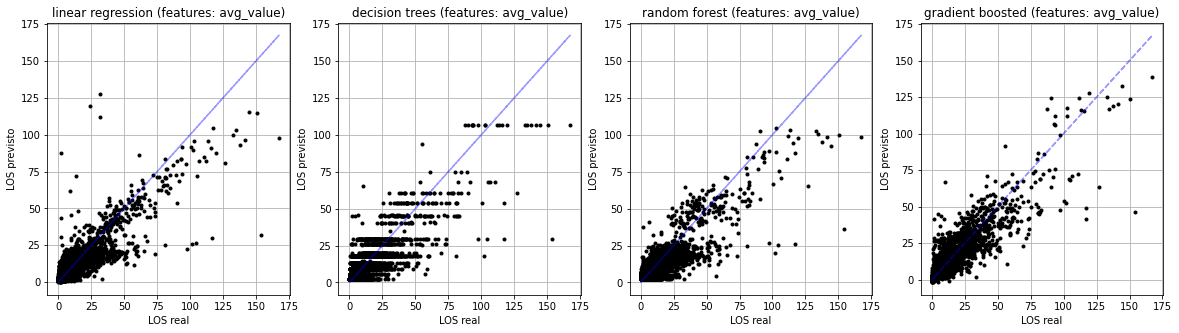

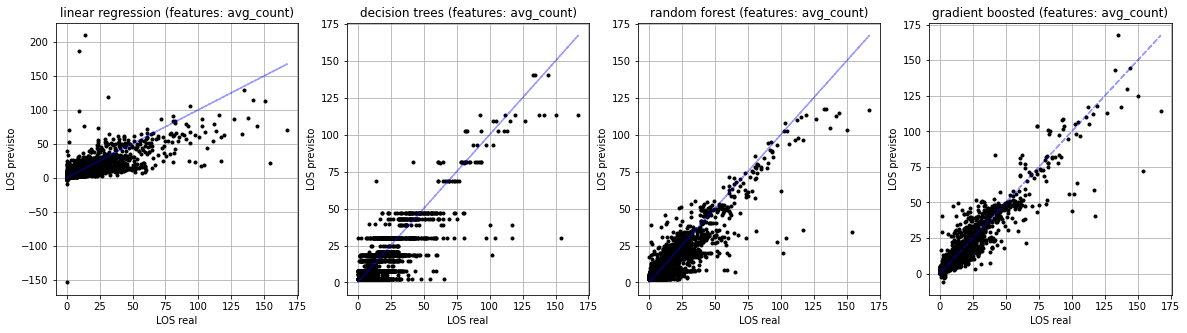

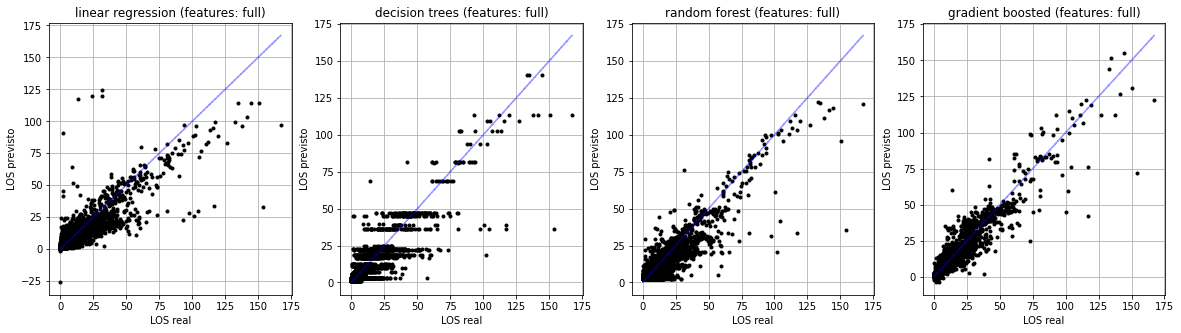

In [365]:
def plot_models(model_set):
    fig, ax = plt.subplots(nrows=1, ncols=4,  figsize=(20, 5))

    for i in range(0,4):
        rows = models[model_set][list(models[model_set].keys())[i]]["predictions"]
        rows = rows.select(["LOS","prediction"]).collect()
        xx = [c[0] for c in rows]
        yy = [c[1] for c in rows]        
        ax[i].plot(xx, yy, '.', color='black')
        ax[i].plot(xx, xx, '--', color='blue',alpha=.4)
        ax[i].set_xlabel("LOS real")
        ax[i].set_ylabel("LOS previsto")
        ax[i].set_title("%s (features: %s)" %(list(models[model_set].keys())[i], model_set))
        ax[i].grid()
        evaluation = models[model_set][list(models[model_set].keys())[i]]["evaluation"]
    plt.show()
    plt.close()

plot_models("avg_value")
plot_models("avg_count")
plot_models("full")

Observando os gráficos, é perceptível que o algorítmo gradient-boosted trees foi aquele que obteve previsões mais aproximadas. É interessante ver que o modelo de regressão linear usando avg_count previu alguns valores de LOS muito desfasados dos valores reais, o que explica o porquê de ser aquele que obteve o pior resultado em termos de RMSE, embora não o tenha sido em termos de MAE.

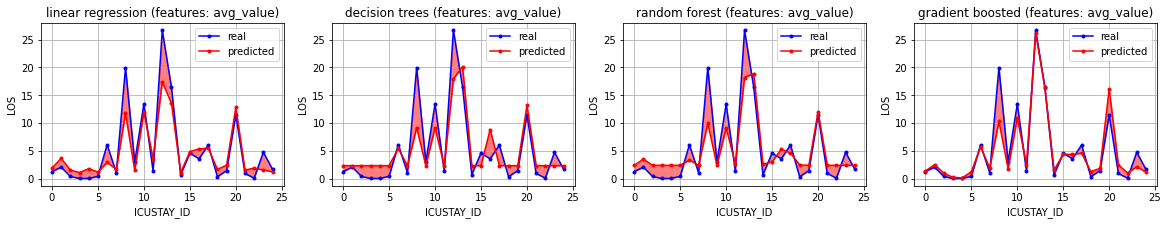

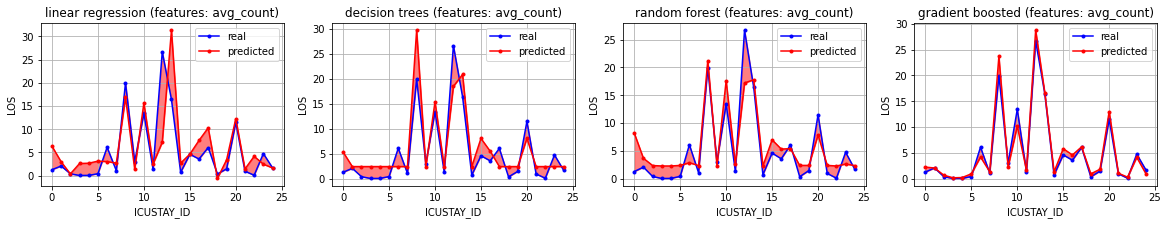

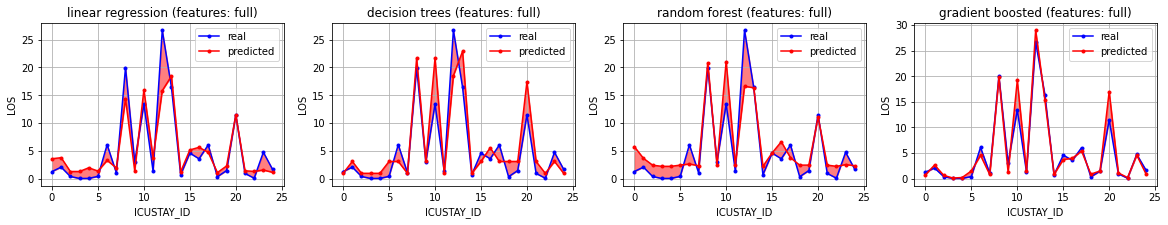

[ DEBUG ] took 83.975157 seconds (1.399586 minutes)


In [145]:
starttime=time.time()

def plot_models2(model_set):

    fig, ax = plt.subplots(nrows=1, ncols=4,  figsize=(20, 3))

    for r in range(0,4):
        df = rows = models[model_set][list(models[model_set].keys())[r]]["predictions"].orderBy("ICUSTAY_ID", ascending=True)
        yy1 = [y[0] for y in df.select("LOS").take(25)]
        yy2 = [y[0] for y in df.select("prediction").take(25)]
        xx = list(range(len(yy1)))
        ax[r].plot(xx,yy1,marker='o',c='blue',markersize=3, label="real")
        ax[r].plot(xx,yy2,marker='o',c='red', markersize=3, label="predicted")
        ax[r].fill_between(xx,yy1,yy2,color="red",alpha=.5)
        ax[r].grid()
        ax[r].set_ylabel("LOS")
        ax[r].set_title("%s (features: %s)" %(list(models[model_set].keys())[r], model_set))
        ax[r].legend(loc="upper right")
        ax[r].set_xlabel("ICUSTAY_ID")
    plt.show()
    plt.close()
    
plot_models2("avg_value")    
plot_models2("avg_count")    
plot_models2("full")    

debug(starttime)

Estes gráficos servem apenas para ilustrar as diferenças entre os valores reais e os previstos, numa pequena amostra com 25 internamentos, ordenados por ordem crescente de ICUSTAY_ID. Mais uma vez, nesta pequena amostra, é visível que o algoritmo gradient boosted trees foi o que se saiu melhor.

## 5. Conclusão <a class="anchor" id="conclusao"></a>
    

Quando se deu início a este trabalho, ainda não era possível ter uma ideia muito concreta sobre o que se tinha em mãos. Era sabido que estávamos perante um dataset de grandes dimensões com dados clínicos, e pouco mais. A grande prioridade inicial era arranjar uma forma de conseguir ler esses dados. Aproveitando a experiência obtida na realização do primeiro trabalho, decidiu-se seguir a seguinte abordagem: utilizar o PySpark para fazer o processamento dos dados, sendo que os dados seriam sempre lidos a partir de um ficheiro parquet. Começou-se por converter o csv com o dataset original no formato parquet e, após cada transformação, escrever o resultado num novo ficheiro parquet. Desta forma, foi possível ir guardando o estado do trabalho e tornar o processamento dos dados muito mais rápido. Resumindo, tentou-se maximizar as potencialidades de hardware localmente, recorrendo a um formato de ficheiros mais apropriado e às capacidades de processamento em paralelo proporcionadas pelo Spark. Em último recurso, caso esta solução não se mostrasse eficaz, recorrer-se-ia ao BigQuery. 

A ideia com que se ficou com a realização deste trabalho é que, seguindo um plano bem estruturado, recorrendo a formatos de armazenamento eficientes e fazendo um bom aproveitamento das capacidades de processamento em paralelo que a generalidade dos computadores atuais possuem, é possível fazer o processamento de grandes quantidades de dados em tempo útil. Há sempre um limite naquilo que os recursos de hardware que temos ao nosso dispor conseguem processar, mas esse limite só é alcançado maximizando-se a eficiência na utilização desses mesmos recursos. Neste trabalho procurou-se atingir esse limite, que se mostrou à altura de suportar o desafio proposto.


## Referências

- [1] https://mimic.physionet.org/mimictables/chartevents/
- [2] https://medlineplus.gov/ency/article/003399.htm
- [3] https://spark.apache.org/docs/2.4.5/ml-classification-regression.html#regression
- API do PySpark: https://spark.apache.org/docs/latest/api/python/pyspark.sql.html 
- API do matplotlib: https://matplotlib.org/3.2.1/api/index.html